In [6]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200

In [7]:
%sql trino://localhost:9090/cuebiq/

'Connected: @cuebiq/'

In [8]:
%%sql
show catalogs

 * trino://localhost:9090/cuebiq/
Done.


,Catalog
0,cuebiq
1,dedicated


In [10]:
import pandas as pd
import numpy as np
from datetime import timedelta
import lightgbm as lgb
from typing import Tuple, Dict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
#import seaborn as sns
#import tensorflow as tf
from sklearn.model_selection import cross_val_score
import shap
import lightgbm as lgb


In [11]:
schema = 'ds_data_for_complexity'

In [12]:
q = f"""show tables from dedicated.{schema}"""
t= %sql $q

 * trino://localhost:9090/cuebiq/
Done.


In [13]:
device_location_table_name = f'dedicated.{schema}.device_location_and_stops_forreal_forreal'

In [14]:
def read_df_all():
    df_all = pd.DataFrame()
    chunksize = 500000
    offset = 0

    while True:
        n_fails = 0
        query = f"""
            SELECT *
            from {device_location_table_name}
            where lineage_id % 20 = 0
            offset {offset}
            limit {chunksize}
            """
      
        df_chunk = %sql $query
        if df_chunk.empty:
            return df_all  # Exit loop if no more data is returned
        df_all = pd.concat([df_all, df_chunk], ignore_index=True)
        offset += chunksize

        print(f"Downloaded {len(df_all)} rows...")  # Optional progress indicator
    print(f"Finished!")
    
df_all = read_df_all()

 * trino://localhost:9090/cuebiq/
Done.
Downloaded 500000 rows...
 * trino://localhost:9090/cuebiq/
Done.
Downloaded 1000000 rows...
 * trino://localhost:9090/cuebiq/
Done.
Downloaded 1500000 rows...
 * trino://localhost:9090/cuebiq/
Done.
Downloaded 2000000 rows...
 * trino://localhost:9090/cuebiq/
Done.
Downloaded 2500000 rows...
 * trino://localhost:9090/cuebiq/
Done.
Downloaded 3000000 rows...
 * trino://localhost:9090/cuebiq/
Done.
Downloaded 3500000 rows...
 * trino://localhost:9090/cuebiq/
Done.
Downloaded 3510541 rows...
 * trino://localhost:9090/cuebiq/
Done.


In [15]:
# df stop

lim_stop_table_name = f'dedicated.{schema}.selected_stops_limited'
query  = f"""
select 
*
from {lim_stop_table_name}
order by zoned_datetime asc
"""
df_stop = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


In [16]:
df_stop = df_stop.sort_values(by="zoned_datetime", ascending=True).reset_index(
    drop=True
)
df_stop["date"] = (
    pd.to_datetime(df_stop["zoned_datetime"], utc=True)
    .dt.tz_convert("America/New_York")
    .dt.date
)


In [17]:
df_all = df_all.sort_values(by="event_zoned_datetime", ascending=True).reset_index(drop=True)
df_all["date"] = (
    pd.to_datetime(df_all["event_zoned_datetime"], utc=True)
    .dt.tz_convert("America/New_York")
    .dt.date
)


### subsampling

In [18]:
# Function to subsample based on time difference
def subsample_trajectory(df, time_threshold):
    subsampled_data = []
    for person_id, group in df.groupby(['lineage_id']):
        previous_time = None
        for index, row in group.iterrows():
            if previous_time is None or (row['datestamp'] - previous_time) > time_threshold:
                subsampled_data.append(row)
                previous_time = row['datestamp']
    return pd.DataFrame(subsampled_data)


In [19]:
def train_val_test_split(df, perc_train, perc_val, date_column, day=10):
    train_date = df[date_column].min()
    while df[df[date_column] <= train_date].shape[0] < perc_train * df.shape[0]:
        train_date += timedelta(days=day)

    val_date = train_date
    while (
        df[(df[date_column] > train_date) & ((df[date_column] <= val_date))].shape[0]
        < perc_val * df.shape[0]
    ):
        val_date += timedelta(days=day)

    test_date = df[date_column].max()

    return train_date, val_date, test_date


def create_datasets(df_all, df_stop, perc_train, perc_val, date_column, day=10):
    train_date, val_date, test_date = train_val_test_split(
        df_stop, perc_train, perc_val, date_column, day
    )

    train_mask = df_all["date"] <= train_date
    val_mask = (df_all["date"] > train_date) & (df_all["date"] <= val_date)
    test_mask = (df_all["date"] > val_date) & (df_all["date"] <= test_date)

    train_data = df_all[train_mask]
    val_data = df_all[val_mask]
    test_data = df_all[test_mask]

    # move stops from one datasets to another to avoid leakage
    train_leak = val_data["stop_id"].isin(train_data["stop_id"].unique()[1:])
    train_data = pd.concat([train_data, val_data[train_leak]])
    print('Train leak shape:', val_data[train_leak]['stop_id'].unique().shape[0])
    val_data = val_data[~train_leak].reset_index(drop=True)

    val_leak = test_data["stop_id"].isin(val_data["stop_id"].unique()[1:])
    val_data = pd.concat([val_data, test_data[val_leak]])
    print('Val leak shape:', test_data[val_leak]['stop_id'].unique().shape[0])
    test_data = test_data[~val_leak].reset_index(drop=True)

    # labels
    y_train = np.zeros(train_data.shape[0])
    y_train[train_data.stop_id.notnull()] = 1
    print('\nPerc. of stop in train:', round(np.sum(y_train)/len(y_train), 3))

    y_val = np.zeros(val_data.shape[0])
    y_val[val_data.stop_id.notnull()] = 1
    print('Perc. of stop in val:', round(np.sum(y_val)/len(y_val), 3))

    y_test = np.zeros(test_data.shape[0])
    y_test[test_data.stop_id.notnull()] = 1
    print('Perc. of stop in test:', round(np.sum(y_test)/len(y_test), 3))

    return (train_data, y_train), (val_data, y_val), (test_data, y_test)


## modeling

### LightGBM

In [20]:
CATEGORICAL_FEATS = ["day_period_code", "dayofweek", "classification_type"]
df_all[CATEGORICAL_FEATS] = df_all[CATEGORICAL_FEATS].astype("str")

NUMERICAL_FEATS = [
#'geo_dens_collective_hourly',
       'geo_dens_individual_hourly', 
    #'geo_dens_collective_weekly',
       'geo_dens_individual_weekly', 'geohash_entropy',
       'num_of_individual_stops_last_hour', 'num_of_individual_stops_last_day',
       'num_of_individual_stops_last_week',
       #'num_of_collective_stops_last_hour', 'num_of_collective_stops_last_day',
       #'num_of_collective_stops_last_week', 
      'space', 'time', 'prev_accuracy',
       'next_accuracy', 'prev_prev_accuracy', 'next_next_accuracy'
]

VOCABULARY = {"Categorical": CATEGORICAL_FEATS, "Numerical": NUMERICAL_FEATS}


def process(df, vocabulary):

    # process numerical data:
    scaler = StandardScaler()
    df[vocabulary["Numerical"]] = scaler.fit_transform(df[vocabulary["Numerical"]])

    # process numerical data:
    encoder = OneHotEncoder(sparse=False, drop="first")
    encoded_df = pd.DataFrame(encoder.fit_transform(df[CATEGORICAL_FEATS]))
    encoded_df.columns = encoder.get_feature_names_out(CATEGORICAL_FEATS)
    df = df.drop(columns=CATEGORICAL_FEATS)
    df = pd.concat([df, encoded_df], axis=1)

    return df


In [21]:
df_all[NUMERICAL_FEATS] = df_all[NUMERICAL_FEATS].fillna(0)

In [22]:
df = process(df_all, VOCABULARY)

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:

train, val, test = create_datasets(df, df_stop, 0.6,0.2, 'date', day = 2)

Train leak shape: 23
Val leak shape: 41

Perc. of stop in train: 0.053
Perc. of stop in val: 0.05
Perc. of stop in test: 0.051


In [24]:
FEATS = [
    #"geo_dens_collective_hourly",
    "geo_dens_individual_hourly",
    #"geo_dens_collective_weekly",
    "geo_dens_individual_weekly",
    "geohash_entropy",
    "num_of_individual_stops_last_hour",
    "num_of_individual_stops_last_day",
    "num_of_individual_stops_last_week",
    #"num_of_collective_stops_last_hour",
    #"num_of_collective_stops_last_day",
    #"num_of_collective_stops_last_week",
    "day_period_code_2",
    "day_period_code_3",
    "day_period_code_4",
    "day_period_code_5",
    "day_period_code_6",
    "dayofweek_2",
    "dayofweek_3",
    "dayofweek_4",
    "dayofweek_5",
    "dayofweek_6",
    "dayofweek_7",
    "classification_type_OTHER",
    "classification_type_PERSONAL_AREA",
    "classification_type_WHITELISTED",
    "accuracy",
    "space",
    "time",
    "prev_accuracy",
    "next_accuracy",
]


## 1. LightGBM

In [25]:
def calculate_metrics(data_set, model, threshold=0.5):
    
    # Step 1: Predict probabilities
    y_proba = model.predict_proba(data_set[0][FEATS])[:, 1]

    # Step 2: Convert probabilities to binary predictions with a threshold of 0.5
    y_pred = (y_proba >= threshold).astype(int)

    # Step 3: Calculate precision, recall, F1 score, and AUC
    y_true = data_set[1]  # Assuming the true labels are in the second element of `test`

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')

    # Step 4: Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)

    # Step 5: Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    # Step 6: Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Step 7: Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


## Overall Result

## Subsampled Stop Result

In [26]:
best_params = {'max_depth': 11,
 'num_leaves': 160,
 'learning_rate': 0.012481352353585853,
 'n_estimators': 417,
 'min_child_samples': 69,
 'subsample': 0.8059895287649028,
 'colsample_bytree': 0.9635362010091966,
 'reg_alpha': 0.004564429974580627,
 'reg_lambda': 0.0046727292778731}

In [27]:

model = lgb.LGBMClassifier(**best_params)
model.fit(
        train[0][FEATS], train[1],
        eval_set=[(val[0][FEATS], val[1])],
        
    )

[LightGBM] [Info] Number of positive: 117817, number of negative: 2092751
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1519
[LightGBM] [Info] Number of data points in the train set: 2210568, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053297 -> initscore=-2.877102
[LightGBM] [Info] Start training from score -2.877102


LGBMClassifier(colsample_bytree=0.9635362010091966,
               learning_rate=0.012481352353585853, max_depth=11,
               min_child_samples=69, n_estimators=417, num_leaves=160,
               reg_alpha=0.004564429974580627, reg_lambda=0.0046727292778731,
               subsample=0.8059895287649028)

In [28]:
temp_test_0 = test[0][~((test[0]["subsampled"]!=1) & (test[0]["stop_id"].isna()==False))]
temp_test_1 = test[1][~((test[0]["subsampled"]!=1) & (test[0]["stop_id"].isna()==False))]
temp_test = (temp_test_0, temp_test_1)

Precision: 0.0270
Recall: 0.7607
F1 Score: 0.0522
AUC: 0.9803


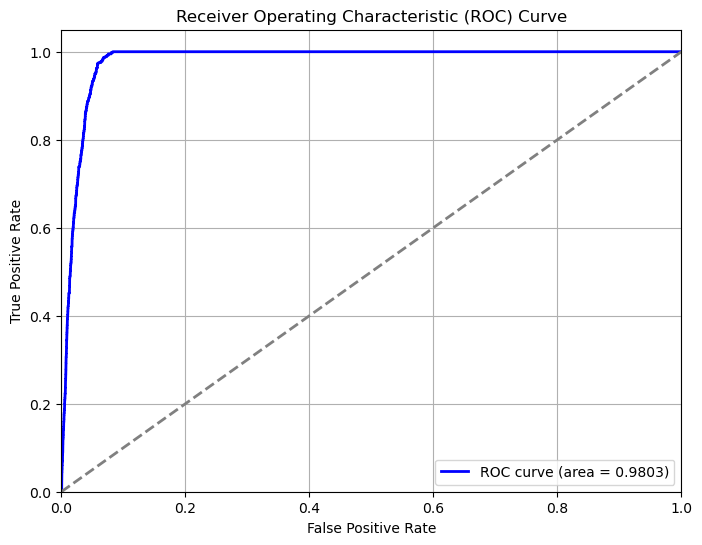

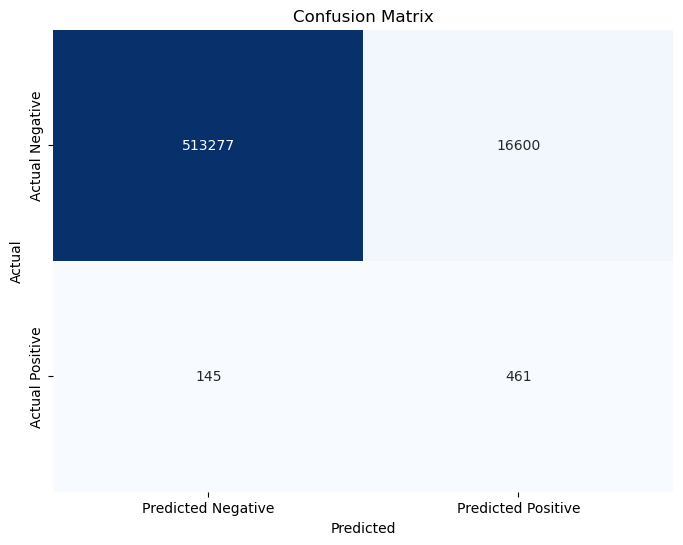

In [34]:
calculate_metrics(temp_test, model, threshold = 0.2)

In [38]:
test[0].shape

(558082, 46)

In [ ]:
mask_false_positive = np.where(())

/srv/conda/envs/notebook/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 114466, number of negative: 1987086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.699741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 2101552, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.054467 -> initscore=-2.854147
[LightGBM] [Info] Start training from score -2.854147


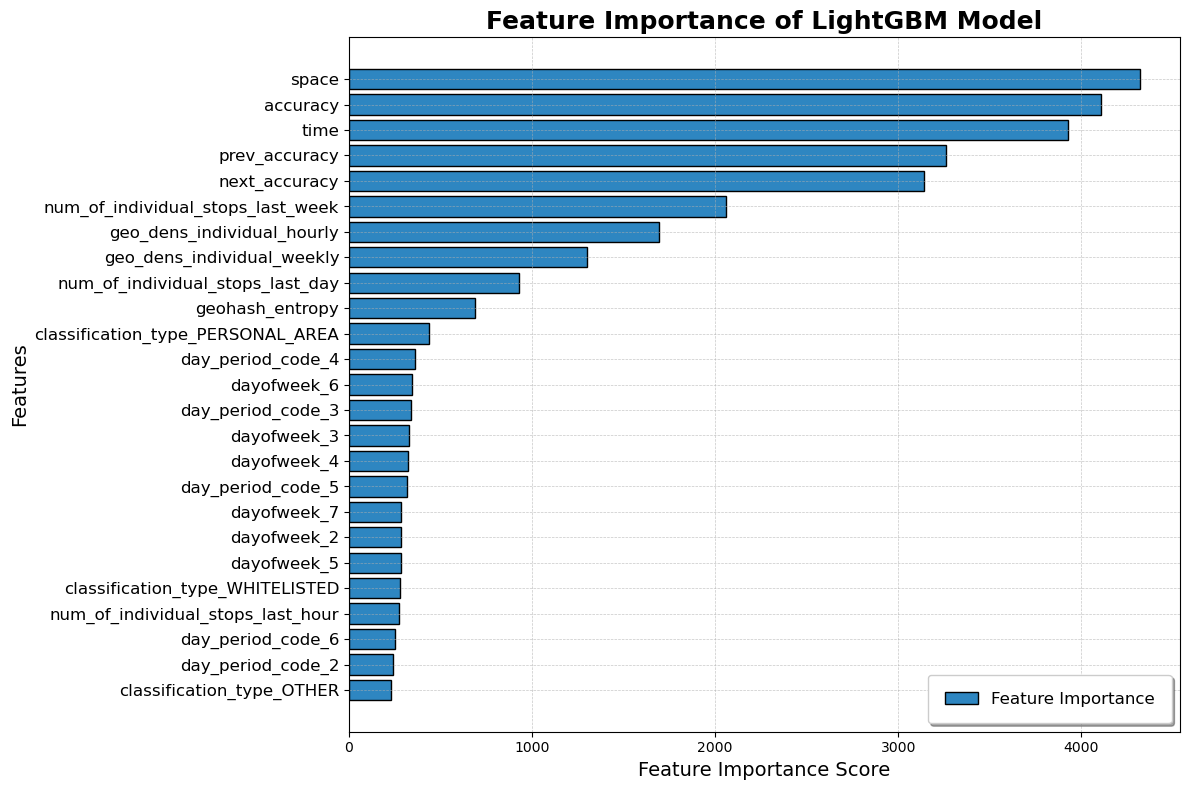

In [65]:
# LightGBM dataset
train_data = lgb.Dataset(train[0][FEATS], label=train[1])
val_data = lgb.Dataset(val[0][FEATS], label=val[1])
test_data = lgb.Dataset(test[0][FEATS], label=test[1])

# Train the model
params = {
    'objective': 'binary',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 1000
}
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Get feature importances
importance = bst.feature_importance()
feature_names = FEATS

# Sort features by importance
indices = np.argsort(importance)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importance[indices], align='center', color='#2E86C1', edgecolor='black', linewidth=1)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=12)
plt.xlabel('Feature Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance of LightGBM Model', fontsize=18, fontweight='bold')

# Adding grid
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend
plt.legend(['Feature Importance'], loc='lower right', fontsize=12, frameon=True, shadow=True, borderpad=1)

# Tight layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


In [35]:
preds = model.predict_proba(temp_test[0][FEATS])[:,1]

pred = np.where(preds>=0.2,1,0)
mask_fp = np.where((temp_test[1]==0) & (pred==1))
fp = temp_test[0].iloc[mask_fp]

mask_fp = np.where((temp_test[1]==0) & (pred==0))
tn = temp_test[0].iloc[mask_fp]

In [36]:
fp[['lineage_id', 'event_zoned_datetime']].to_csv("false_positive_last.csv")
tn[['lineage_id', 'event_zoned_datetime']].to_csv("true_negative_last.csv")

In [ ]:

# Initialize the SHAP explainer
explainer = shap.Explainer(model, train[0][FEATS])

# Compute SHAP values for the test set
shap_values = explainer(temp_test[0][FEATS])

# Visualize the SHAP values for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

# Visualize SHAP values for all predictions
shap.summary_plot(shap_values, X_test)

In [39]:
del model

### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
# Step 4: Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train[0][FEATS], train[1],)

RandomForestClassifier(random_state=42)

Precision: 0.0263
Recall: 0.8086
F1 Score: 0.0509
AUC: 0.9781


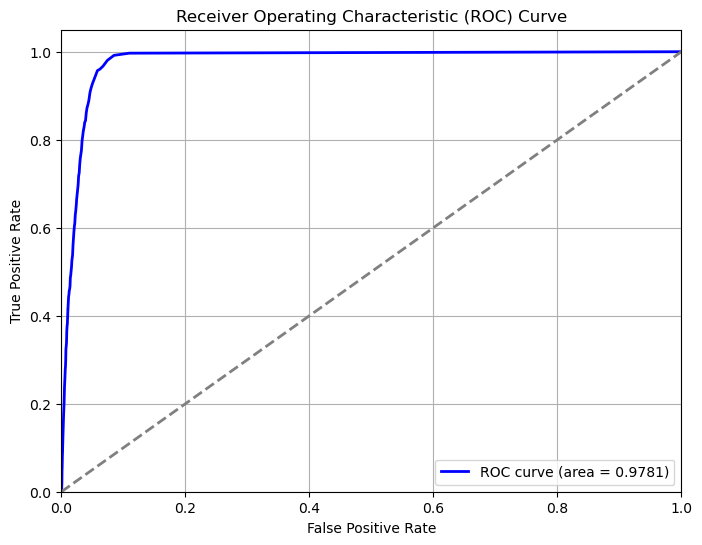

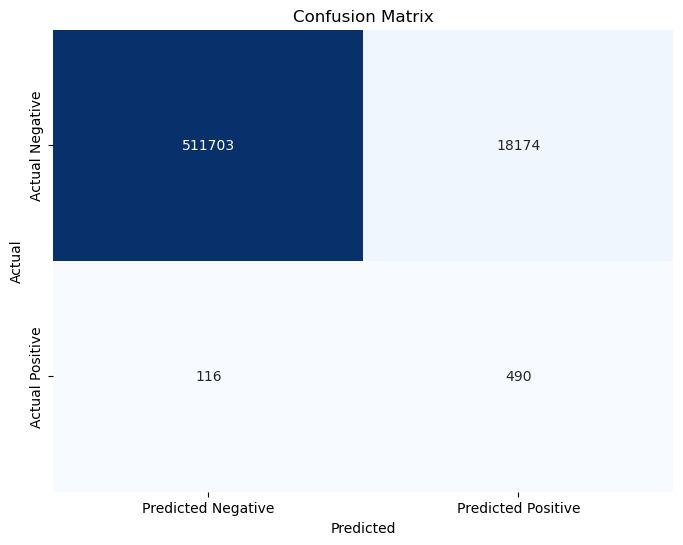

In [42]:
calculate_metrics(temp_test, clf, threshold = 0.2)

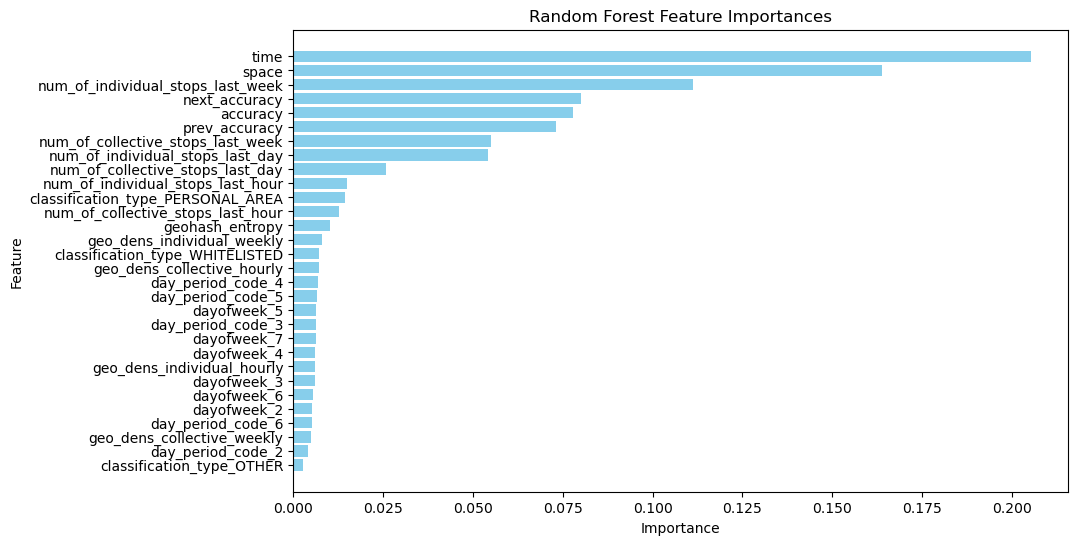

In [58]:
# Extract feature importances
importances = clf.feature_importances_
features = FEATS

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

### NeuralNet

In [59]:
train, val, test = create_datasets(df, df_stop, 0.6,0.2, 'date', day = 5)

Train leak shape: 16
Val leak shape: 16

Perc. of stop in train: 0.052
Perc. of stop in val: 0.051
Perc. of stop in test: 0.041


In [43]:
def dense_block(
    inputs: tf.keras.layers,
    units: int,
    dropout_rate: float,
    activation: str = "swish",
) -> tf.keras.layers:
    """
    Dense block used in the model.

    Args:
        inputs (tf.keras.layers): input layer.
        units (int): number of units in the dense layer.
        dropout_rate (float): dropout rate.
        activation (str): activation function.

    Returns:
        tf.keras.layers: dense layer.
    """
    dense = tf.keras.layers.Dense(units, activation=activation)(inputs)
    drop = tf.keras.layers.Dropout(dropout_rate)(dense)
    bnorm = tf.keras.layers.BatchNormalization()(drop)
    return bnorm

In [44]:
import tensorflow as tf

# Define the input layer
inputs = tf.keras.Input(shape=(len(FEATS),), name="input_features")

# First dense layer with batch normalization and dropout
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)

# Output layer with sigmoid activation for binary classification
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)     │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,969 (15.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [49]:
def f1_metric(y_true, y_pred):
    y_pred_labels = tf.round(y_pred)
    tp = tf.keras.backend.sum(tf.keras.backend.round(y_true * y_pred_labels))  # True Positives
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(y_pred_labels))  # Predicted Positives
    actual_positives = tf.keras.backend.sum(y_true)  # Actual Positives
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (actual_positives + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1
# Compile the model with custom metric
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = [f1_metric, 'accuracy'])


In [50]:
model.fit(train[0][FEATS], train[1], epochs=5, batch_size=128, validation_data=(val[0][FEATS],val[1]))


Epoch 1/5
14929/14929 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.9649 - f1_metric: 6.0513 - loss: 0.0811 - val_accuracy: 0.9693 - val_f1_metric: 5.5843 - val_loss: 0.0737
Epoch 2/5
14929/14929 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9674 - f1_metric: 6.2340 - loss: 0.0742 - val_accuracy: 0.9697 - val_f1_metric: 5.3498 - val_loss: 0.0721
Epoch 3/5
14929/14929 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9679 - f1_metric: 6.2858 - loss: 0.0728 - val_accuracy: 0.9687 - val_f1_metric: 5.7467 - val_loss: 0.0714
Epoch 4/5
14929/14929 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9683 - f1_metric: 6.3314 - loss: 0.0715 - val_accuracy: 0.9700 - val_f1_metric: 5.3102 - val_loss: 0.0696
Epoch 5/5
14929/14929 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9689 - f1_metric: 6.3074 - loss: 0.0704 - val_accuracy: 0.9700 - val_f1_metric: 5.6073 - val_loss: 0.0692


In [70]:
temp_test_0 = test[0][~((test[0]["subsampled"]!=1) & (test[0]["stop_id"].isna()==False))]
temp_test_1 = test[1][~((test[0]["subsampled"]!=1) & (test[0]["stop_id"].isna()==False))]
temp_test = (temp_test_0, temp_test_1)

In [51]:
y_proba = model.predict(temp_test[0][FEATS])

16578/16578 ━━━━━━━━━━━━━━━━━━━━ 13s 806us/step


Precision: 0.0228
Recall: 0.7574
F1 Score: 0.0442
AUC: 0.9717


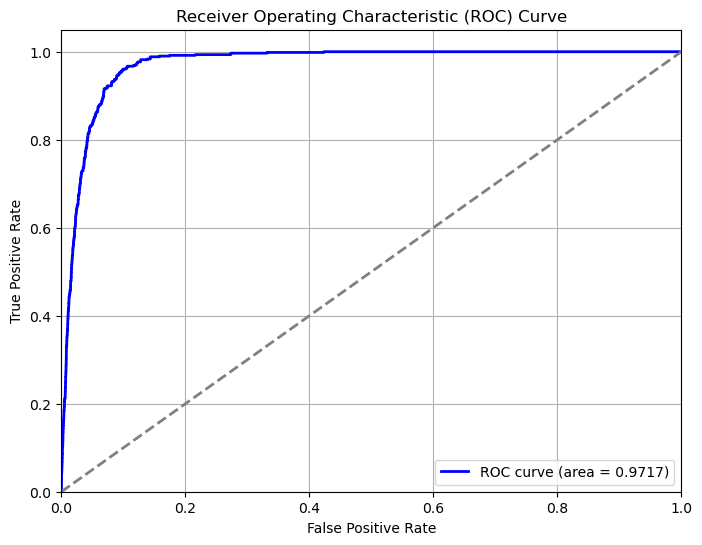

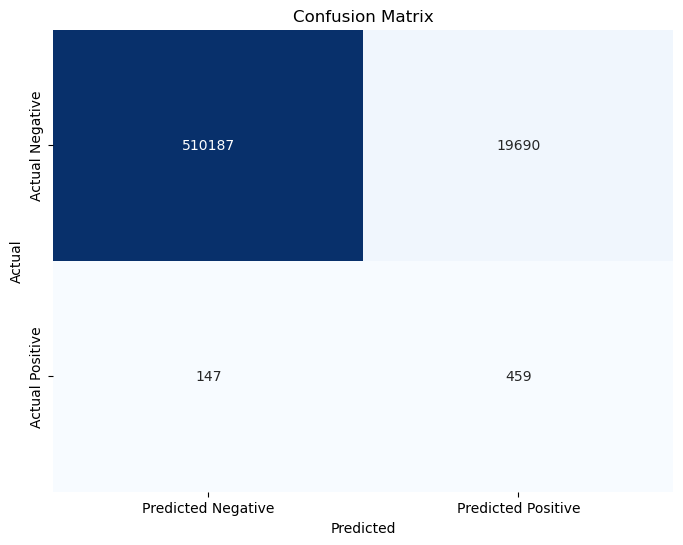

In [52]:

# Step 2: Convert probabilities to binary predictions with a threshold of 0.5
y_pred = (y_proba >= 0.2).astype(int)

# Step 3: Calculate precision, recall, F1 score, and AUC
y_true = temp_test[1]  # Assuming the true labels are in the second element of `test`

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_proba)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')

# Step 4: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

# Step 5: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
# Step 6: Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 7: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [57]:
!pip install sklearn-rvm

In [ ]:
# Create a SHAP explainer
explainer = shap.Explainer(model)

# Compute SHAP values for the test set
shap_values = explainer(temp_test[0][FEATS])